# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/mia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Importing the data

In [2]:
# Read the data
df = pd.read_csv('book_genre_dataset.csv')

# Get shape and head
print(df.shape)
df.head()

(4657, 4)


,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [3]:
# Get the labels
labels = df.genre
labels.head()

0    fantasy
1    fantasy
2    fantasy
3    fantasy
4    fantasy
Name: genre, dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4657 entries, 0 to 4656
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    4657 non-null   int64 
 1   title    4657 non-null   object
 2   genre    4657 non-null   object
 3   summary  4657 non-null   object
dtypes: int64(1), object(3)
memory usage: 145.7+ KB


# Data exploration

In [5]:
# Get genre value counts
genre_counts = df['genre'].value_counts()

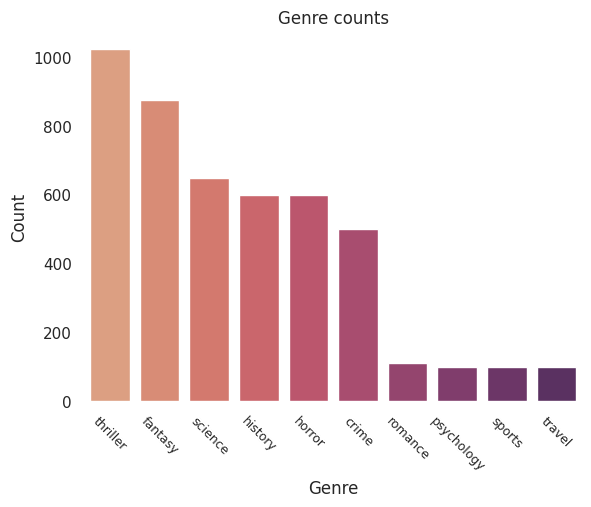

In [6]:
# Initialize the matplotlib figure
fig, ax = plt.subplots()

# Plot the data
sns.barplot(
    x = genre_counts.index,
    y = genre_counts,
    palette = 'flare'
)

# Add axis labels, make pretty
plt.title('Genre counts')
ax.set(
    xlabel = "Genre",
    ylabel = "Count"
)
ax.tick_params(axis='x', labelrotation=-45, labelsize=9)
sns.despine(left=True, bottom=True)

Text(0.5, 1.0, 'Genre percentages')

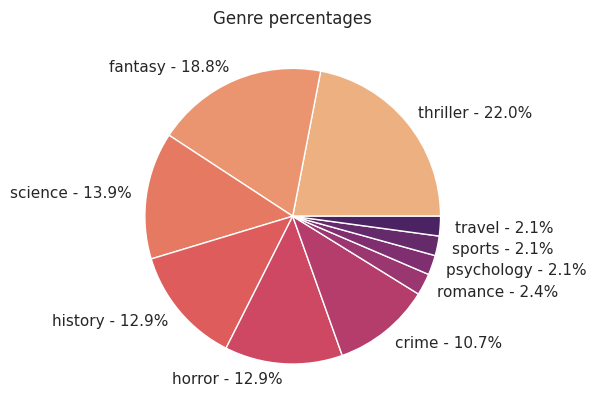

In [7]:
percentages = 100 * genre_counts / genre_counts.sum()
labels = [f"{x} - {y:.1f}%" for x,y in zip(genre_counts.index,percentages)]
colors = plt.get_cmap('flare')(np.linspace(0,1,len(percentages)))

plt.figure()

plt.pie(
    x=genre_counts,
    labels=labels,
    colors=colors
)

plt.title("Genre percentages")

# Text Preprocessing

- lowercase
- remove punctuation
- remove stopwords
- stemming/lemmatization
- combine title and summary into new column

In [8]:
# Create new column with combined title and summary
df['combined'] = df['title'] + ' ' + df['summary']

In [9]:
# Make everything lowercase
def lowercase(text):
    text = text.lower()
    return text

# Remove punctuation
def remove_punct(text):
    text = re.sub(r'[^\w\s]|_', '', text)
    return text

# Remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = ' '.join([w for w in text.split() if w not in stop_words])
    return text

# Lemmatize tokens
def get_lemmas(text):
    wnl = WordNetLemmatizer()
    text = ' '.join([wnl.lemmatize(w) for w in text.split()])
    return text

In [10]:
# Preprocessing
def preprocessing(text):
    text = lowercase(text)
    text = remove_punct(text)
    text = remove_stopwords(text)
    text = get_lemmas(text)
    return text

In [11]:
df['combined'] = df['combined'].apply(preprocessing)